Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Sampling: [likelihood]


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Shape of X_train_full: (472, 1)
Shape of posterior predictive: (4, 3000, 472)
Shape of predicted_means_improved_original: (472, 1)


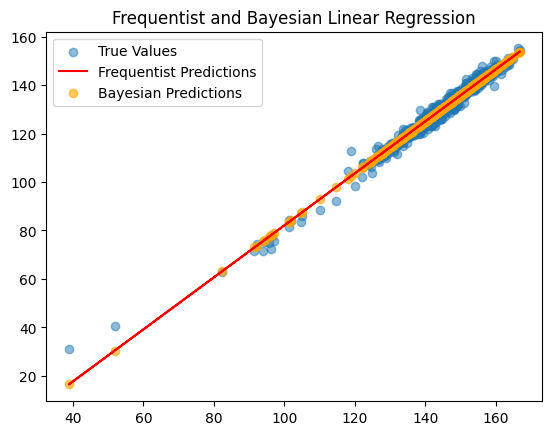

Frequentist Linear Regression
MSE: 4.813889496399352
MAE: 1.6477843172795925
Bayesian Linear Regression
MSE: 4.807109923465496
MAE: 1.6464105727198242


In [25]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('Crab_molt.csv')
data = data.rename(columns={'pre molt size': 'presz', 'post molt size': 'postsz'})

# Drop NaN values
data = data.dropna()

# Use the full dataset
X_train_full = data[['postsz']]
y_train_full = data['presz']

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_full_scaled = scaler_X.fit_transform(X_train_full)
y_train_full_scaled = scaler_y.fit_transform(y_train_full.values.reshape(-1, 1))

# Frequentist Linear Regression
frequentist_model = LinearRegression()
frequentist_model.fit(X_train_full_scaled, y_train_full_scaled)
y_pred_frequentist = frequentist_model.predict(X_train_full_scaled)

# Inverse transform the predicted values back to the original scale
y_pred_frequentist_original = scaler_y.inverse_transform(y_pred_frequentist)

# Bayesian Linear Regression with tighter priors and normal likelihood
with pm.Model() as improved_bayesian_model:
    # Priors for intercept and slope
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope = pm.Normal('slope', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Linear model
    mu = intercept + slope * X_train_full_scaled.flatten()
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_train_full_scaled.flatten())
    
    # Sample from the posterior
    trace_improved = pm.sample(3000, return_inferencedata=True)

# Posterior predictive checks
with improved_bayesian_model:
    ppc_improved = pm.sample_posterior_predictive(trace_improved, var_names=["likelihood"], return_inferencedata=True)

# Check the shape of X_train_full and ppc_improved.posterior_predictive['likelihood']
print(f"Shape of X_train_full: {X_train_full.shape}")
print(f"Shape of posterior predictive: {ppc_improved.posterior_predictive['likelihood'].shape}")

# Take the mean of the posterior predictive samples along the draw axis (axis 1)
# The shape is (chain, draw, observations), so we need to average over both chain and draw
predicted_means_improved = ppc_improved.posterior_predictive['likelihood'].mean(dim=["chain", "draw"])

# Convert the DataArray to a NumPy array
predicted_means_improved_np = predicted_means_improved.values

# Inverse transform the predicted values back to the original scale
predicted_means_improved_original = scaler_y.inverse_transform(predicted_means_improved_np.reshape(-1, 1))

# Check the shape of predicted_means_improved_original
print(f"Shape of predicted_means_improved_original: {predicted_means_improved_original.shape}")

# Ensure the shapes of X_train_full and predicted_means_improved_original match before plotting
plt.scatter(X_train_full, y_train_full, label="True Values", alpha=0.5)
plt.plot(X_train_full, y_pred_frequentist_original, color='red', label="Frequentist Predictions")
plt.scatter(X_train_full, predicted_means_improved_original, color='orange', label="Bayesian Predictions", alpha=0.6)
plt.legend()
plt.title('Frequentist and Bayesian Linear Regression')
plt.show()

# Print performance metrics for the frequentist model
print("Frequentist Linear Regression")
print(f"MSE: {mean_squared_error(y_train_full, y_pred_frequentist_original)}")
print(f"MAE: {mean_absolute_error(y_train_full, y_pred_frequentist_original)}")

# Print performance metrics for the Bayesian model
mse_improved = mean_squared_error(y_train_full, predicted_means_improved_original)
mae_improved = mean_absolute_error(y_train_full, predicted_means_improved_original)

print("Bayesian Linear Regression")
print(f"MSE: {mse_improved}")
print(f"MAE: {mae_improved}")

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.000  0.006  -0.013    0.012        0.0      0.0   18983.0   
slope      0.990  0.006   0.978    1.002        0.0      0.0   17396.0   
sigma      0.139  0.005   0.131    0.148        0.0      0.0   16493.0   

           ess_tail  r_hat  
intercept    9730.0    1.0  
slope        7721.0    1.0  
sigma        9170.0    1.0  


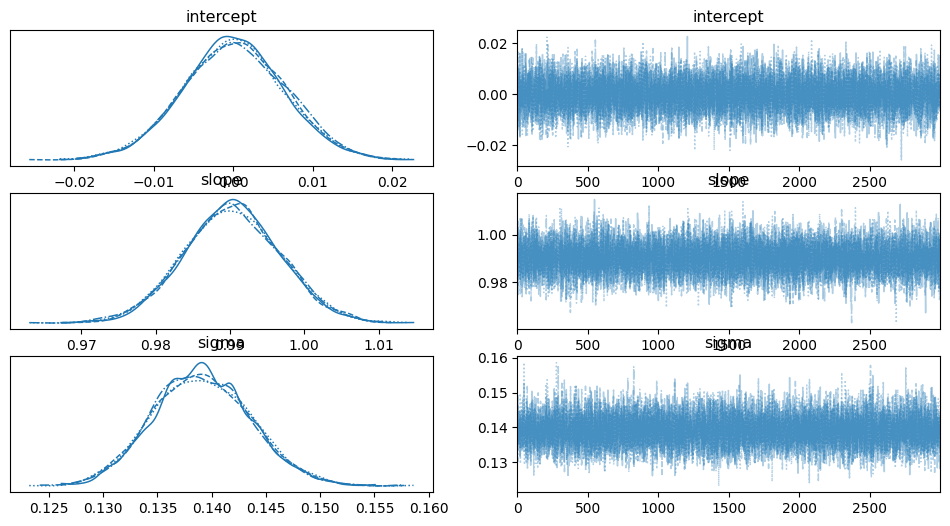

In [26]:
# Check convergence diagnostics using ArviZ
print(az.summary(trace_improved))  # Look for r_hat close to 1

# Plot trace plots for the parameters to visually inspect convergence
az.plot_trace(trace_improved)
plt.show()

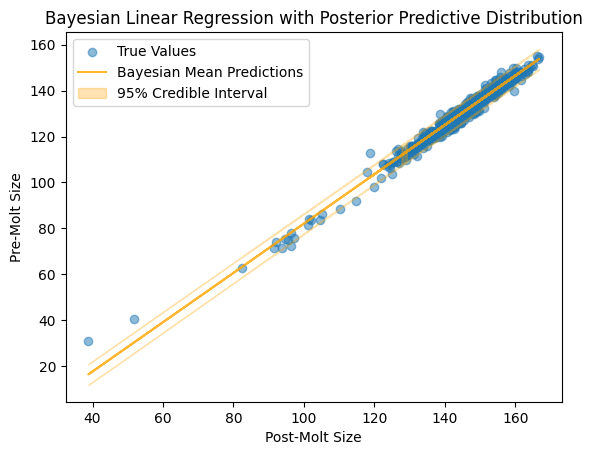

In [29]:
# Extract posterior predictive samples as a NumPy array
posterior_predictive_samples = ppc_improved.posterior_predictive['likelihood'].values  # Shape: (chain, draw, observations)

# Calculate the mean, 2.5th and 97.5th percentiles for each observation
predicted_means_improved = posterior_predictive_samples.mean(axis=(0, 1))  # Mean over chain and draw
predicted_lower_bound = np.percentile(posterior_predictive_samples, 2.5, axis=(0, 1))  # 2.5th percentile (lower bound)
predicted_upper_bound = np.percentile(posterior_predictive_samples, 97.5, axis=(0, 1))  # 97.5th percentile (upper bound)

# Inverse transform the predicted values back to the original scale
predicted_means_improved_original = scaler_y.inverse_transform(predicted_means_improved.reshape(-1, 1))
predicted_lower_bound_original = scaler_y.inverse_transform(predicted_lower_bound.reshape(-1, 1))
predicted_upper_bound_original = scaler_y.inverse_transform(predicted_upper_bound.reshape(-1, 1))

# Plot the true values
plt.scatter(X_train_full, y_train_full, label="True Values", alpha=0.5)

# Plot Bayesian predictions (mean)
plt.plot(X_train_full.values.flatten(), predicted_means_improved_original, color='orange', label="Bayesian Mean Predictions", alpha=0.8)

# Plot the 95% credible interval (shaded area)
plt.fill_between(X_train_full.values.flatten(), 
                 predicted_lower_bound_original.flatten(), 
                 predicted_upper_bound_original.flatten(),
                 color='orange', alpha=0.3, label="95% Credible Interval")

# Add labels, legend, and title
plt.legend()
plt.title('Bayesian Linear Regression with Posterior Predictive Distribution')
plt.xlabel('Post-Molt Size')
plt.ylabel('Pre-Molt Size')
plt.show()


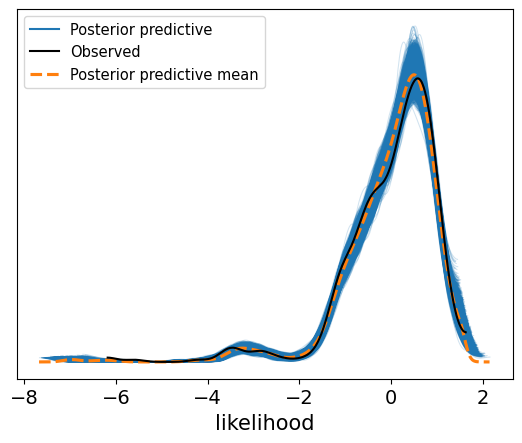

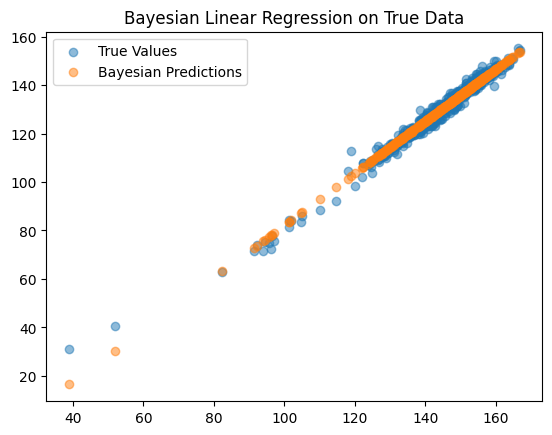

Bayesian Model MSE on True Data: 4.807109923465496
Bayesian Model MAE on True Data: 1.6464105727198242


In [33]:
import arviz as az

# Visualize posterior predictive distribution using ArviZ
az.plot_ppc(ppc_improved)  # InferenceData is already PyMC v4 compatible, no need for from_pymc3
plt.show()

# Bayesian predictions (mean values of posterior predictive)
predicted_means_improved = posterior_predictive_samples.mean(axis=(0, 1))  # Mean across chain and draw

# Inverse transform predictions and true values back to original scale
y_improved_pred_original = scaler_y.inverse_transform(predicted_means_improved.reshape(-1, 1))
y_train_full_original = scaler_y.inverse_transform(y_train_full_scaled)

# Plot the true values vs predictions
plt.scatter(X_train_full, y_train_full_original, label="True Values", alpha=0.5)
plt.scatter(X_train_full, y_improved_pred_original, label="Bayesian Predictions", alpha=0.5)
plt.legend()
plt.title('Bayesian Linear Regression on True Data')
plt.show()

# Calculate performance metrics
mse_improved = mean_squared_error(y_train_full_original, y_improved_pred_original)
mae_improved = mean_absolute_error(y_train_full_original, y_improved_pred_original)

print(f"Bayesian Model MSE on True Data: {mse_improved}")
print(f"Bayesian Model MAE on True Data: {mae_improved}")

## Student Performance Data

In [4]:
import pymc as pm
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as at

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [5]:
n_samples = 30

w0 = 2.0
w1 = 4.5

x = np.sort(np.random.rand(n_samples))
y = w1 * x + w0 + np.random.rand(n_samples)

In [6]:
model = pm.Model()

with model:
    w0_hat = pm.Normal("w0", mu=0, sigma=10)
    w1_hat = pm.Normal("w1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = w0_hat + w1_hat * x  

    y_hat = pm.Normal("y_hat", mu=mu, sigma=sigma, observed=y)

In [7]:
with model:
    sample = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w0, w1, sigma]


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'w0'}>, <Axes: title={'center': 'w0'}>],
       [<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

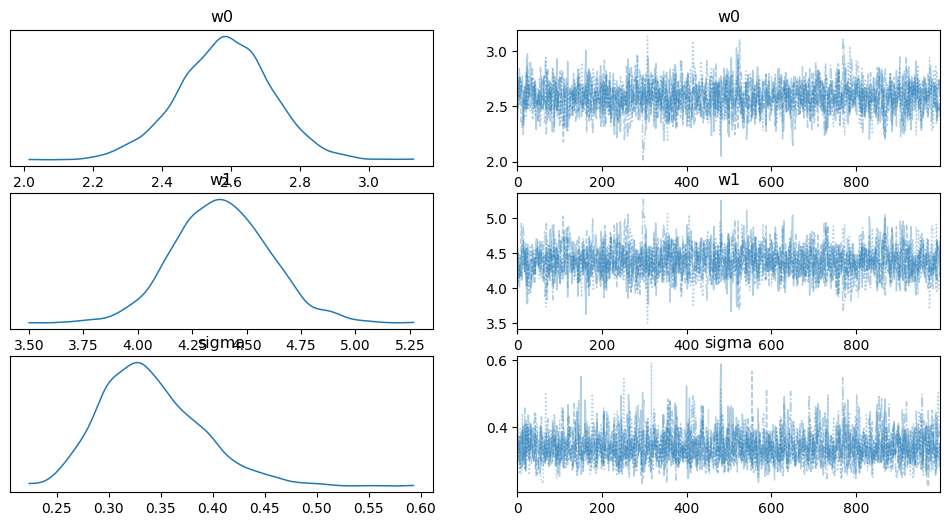

In [8]:
az.plot_trace(sample, combined=True)

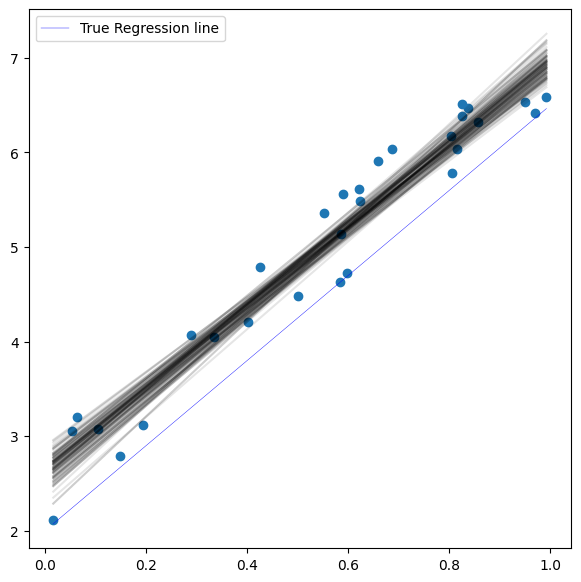

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(x, y)

# extract intercept(w0) draws from PyMC
w0_ = sample.posterior.w0.to_numpy()[0]
w1_ = sample.posterior.w1.to_numpy()[0]

sample_indexes = np.random.randint(len(w0_), size=100)

for i in sample_indexes:
    y_line = w0_[i] + w1_[i] * x
    ax.plot(x, y_line, c='black', alpha=0.1)

true_y = w0 + w1 * x
ax.plot(x, true_y, label="True Regression line", lw=.3, c='blue')
ax.legend(loc=0)
plt.show()

In [10]:
df = pd.read_csv('Student_performance.csv')
df.head(3)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0


array([[<Axes: xlabel='Hours Studied', ylabel='Hours Studied'>,
        <Axes: xlabel='Previous Scores', ylabel='Hours Studied'>,
        <Axes: xlabel='Sleep Hours', ylabel='Hours Studied'>,
        <Axes: xlabel='Sample Question Papers Practiced', ylabel='Hours Studied'>,
        <Axes: xlabel='Performance Index', ylabel='Hours Studied'>],
       [<Axes: xlabel='Hours Studied', ylabel='Previous Scores'>,
        <Axes: xlabel='Previous Scores', ylabel='Previous Scores'>,
        <Axes: xlabel='Sleep Hours', ylabel='Previous Scores'>,
        <Axes: xlabel='Sample Question Papers Practiced', ylabel='Previous Scores'>,
        <Axes: xlabel='Performance Index', ylabel='Previous Scores'>],
       [<Axes: xlabel='Hours Studied', ylabel='Sleep Hours'>,
        <Axes: xlabel='Previous Scores', ylabel='Sleep Hours'>,
        <Axes: xlabel='Sleep Hours', ylabel='Sleep Hours'>,
        <Axes: xlabel='Sample Question Papers Practiced', ylabel='Sleep Hours'>,
        <Axes: xlabel='Performance 

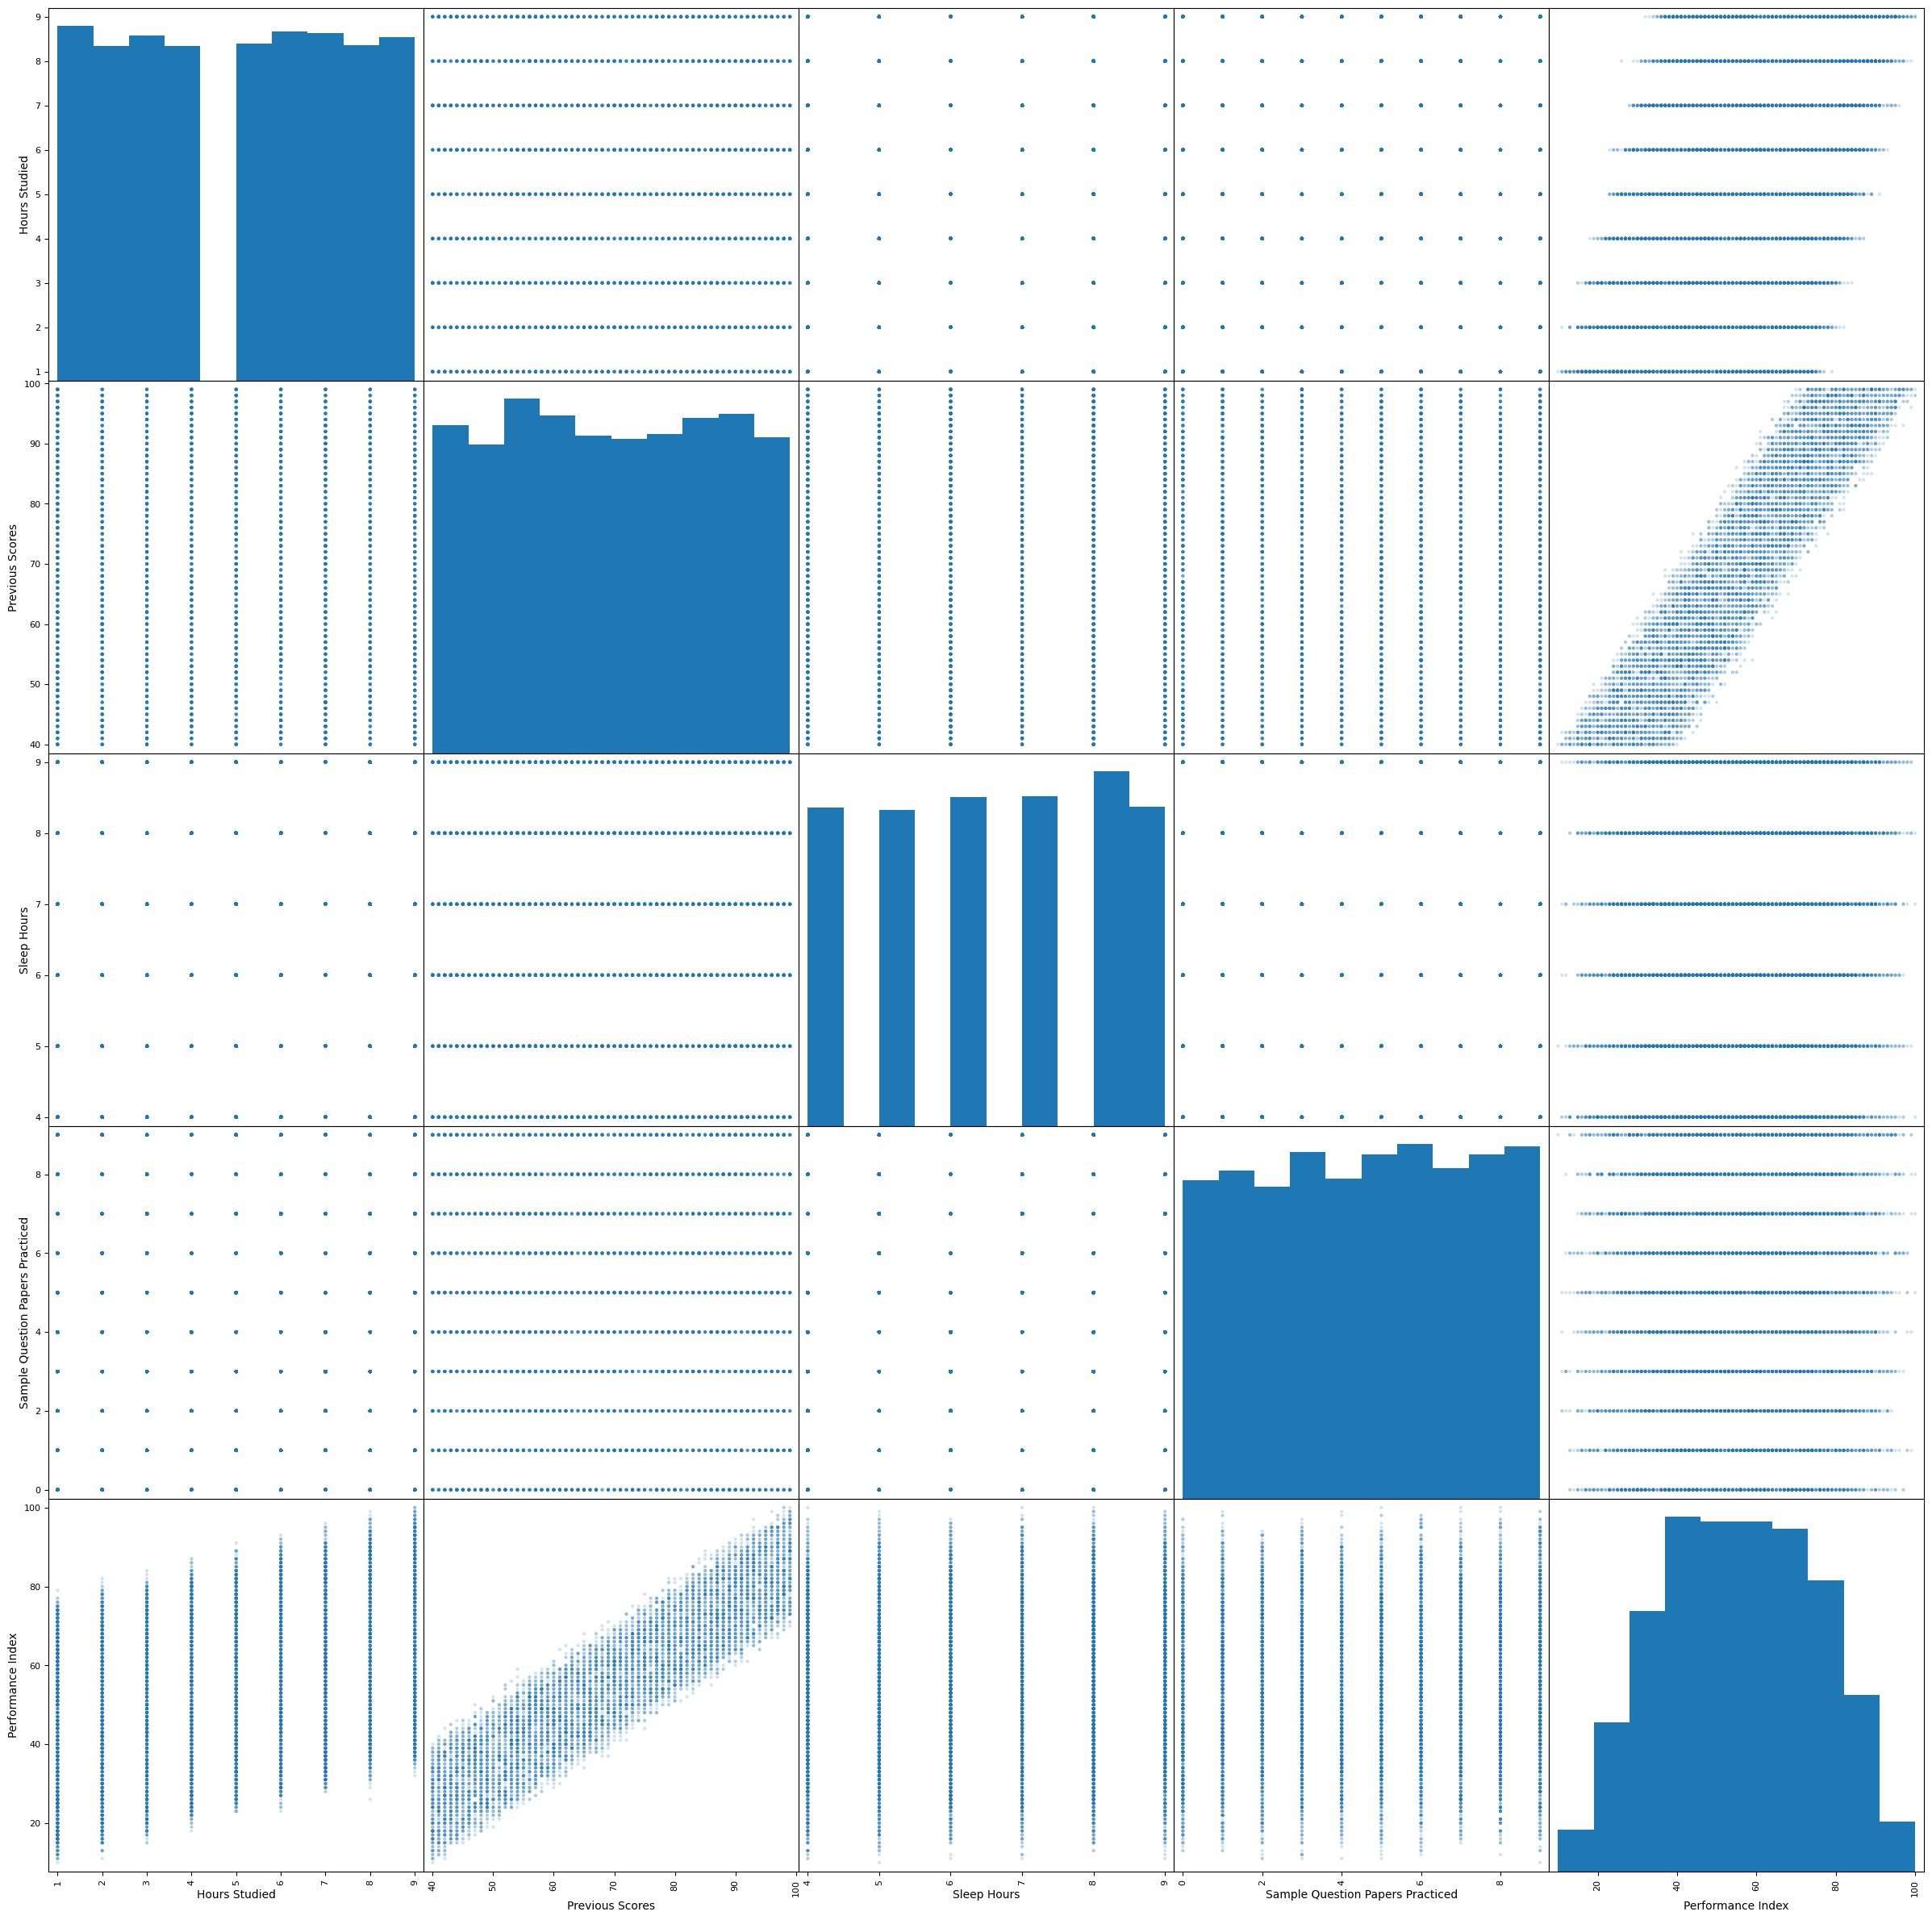

In [11]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(30, 30))

In [12]:
le = LabelEncoder()

df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])

In [13]:
df = df[~df.duplicated()]
df = df.dropna().astype(float)

columns = df.columns.values[:-1] 

In [14]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X = X.astype(float)
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('train and test size')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

train and test size
(8885, 5) (988, 5) (8885,) (988,)


In [15]:
test_score_bayesian = pm.Model(coords={"predictors": columns})

with test_score_bayesian:
    # posterior variance
    sigma = pm.HalfNormal("sigma", 25)

    # beta
    beta = pm.Normal("beta", 0, 10, dims="predictors")
    beta0 = pm.Normal("beta0", 0, 10)

    mu = beta0 + at.dot(X_train, beta)
    
    y_hat = pm.Normal("y_hat", mu=mu, sigma=sigma, observed=y_train)

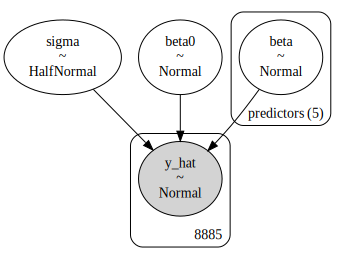

In [16]:
pm.model_to_graphviz(test_score_bayesian)

In [17]:
with test_score_bayesian:
    sample = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, beta0]


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

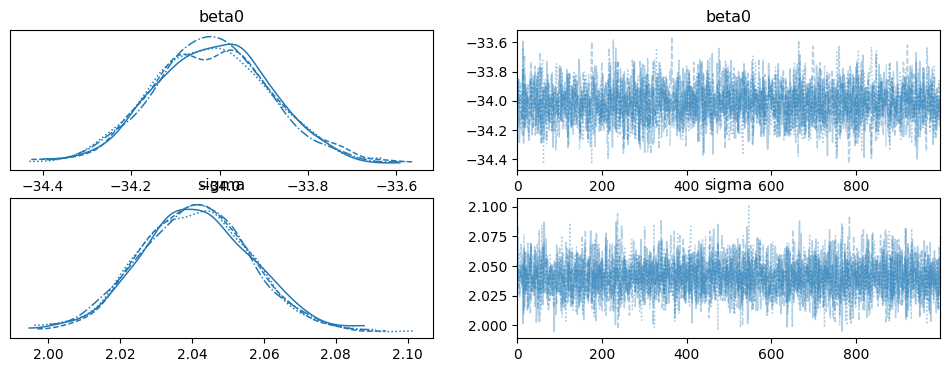

In [18]:
az.plot_trace(sample, var_names=["beta0", "sigma"])

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

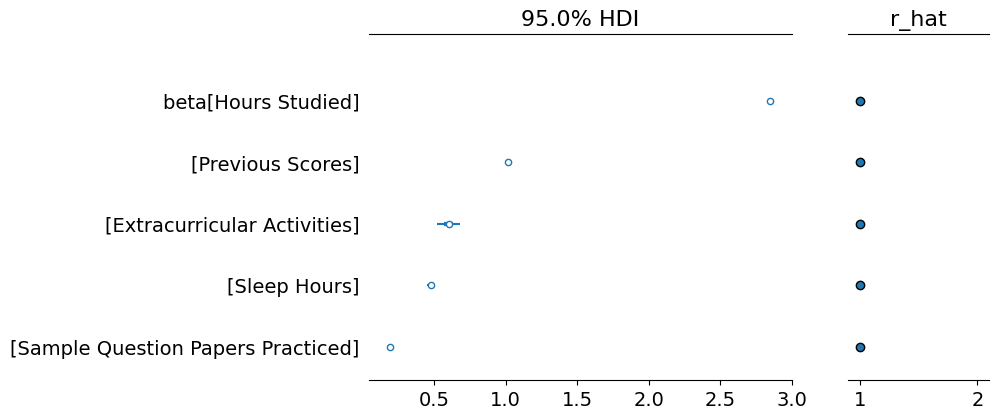

In [19]:
az.plot_forest(sample, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)

In [20]:
az.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Hours Studied],2.852,0.008,2.836,2.867,0.000,0.000,3938.0,2725.0,1.0
beta[Previous Scores],1.018,0.001,1.016,1.021,0.000,0.000,3488.0,2633.0,1.0
beta[Extracurricular Activities],0.600,0.043,0.522,0.680,0.001,0.000,4055.0,2829.0,1.0
beta[Sleep Hours],0.475,0.013,0.451,0.499,0.000,0.000,3670.0,2999.0,1.0
beta[Sample Question Papers Practiced],0.192,0.008,0.178,0.206,0.000,0.000,3974.0,2735.0,1.0
beta0,-34.018,0.132,-34.249,-33.752,0.002,0.002,2930.0,2582.0,1.0
sigma,2.041,0.015,2.012,2.069,0.000,0.000,4208.0,3033.0,1.0
